[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Wed Dec  4 17:58:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [4]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [5]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00


### Download SAM weights

In [6]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

Saving mmsTable.jpg to mmsTable.jpg
Image uploaded: mmsTable.jpg


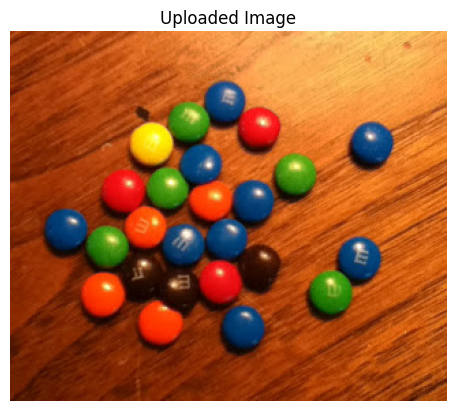

In [42]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload the image
uploaded = files.upload()  # Prompts file upload dialog
if not uploaded:
    raise FileNotFoundError("No file uploaded.")

# Get the uploaded file name
image_file = list(uploaded.keys())[0]
print(f"Image uploaded: {image_file}")

# Load and display the image
image = Image.open(image_file)
plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()


## Load Model

In [43]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [44]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [108]:
mask_generator = SamAutomaticMaskGenerator(sam)

Saving mmsTable.jpg to mmsTable (2).jpg
Image uploaded: mmsTable (2).jpg
Image path: mmsTable (2).jpg


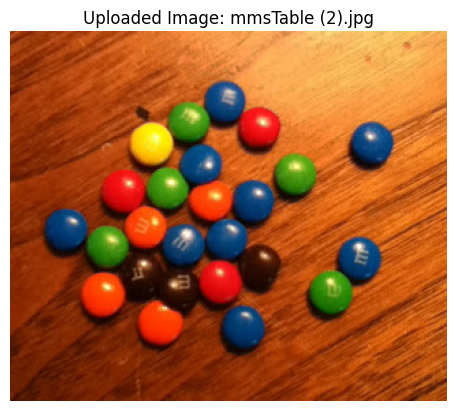

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [122]:
# Upload the image
uploaded = files.upload()  # Prompts file upload dialog

# Check if a file was uploaded
if not uploaded:
    raise FileNotFoundError("No file uploaded. Please select an image.")

# Get the uploaded file name
IMAGE_NAME = list(uploaded.keys())[0]  # The name of the uploaded image
IMAGE_PATH = IMAGE_NAME  # Path to the uploaded image (it's in the current directory by default)

# Print the image details
print(f"Image uploaded: {IMAGE_NAME}")
print(f"Image path: {IMAGE_PATH}")

# Load and display the image
image = Image.open(IMAGE_PATH)
plt.imshow(image)
plt.axis("off")
plt.title(f"Uploaded Image: {IMAGE_NAME}")
plt.show()

# Now you can continue with your code
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Checkpoint path for SAM model
CHECKPOINT_PATH = os.path.join("/content", "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

# Initialize SAM model and mask generator
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

### Generate masks with SAM

In [123]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [124]:
print(sam_result[0].keys())

print(sam_result[0]['segmentation'])
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[[False False False ... False False False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]]


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

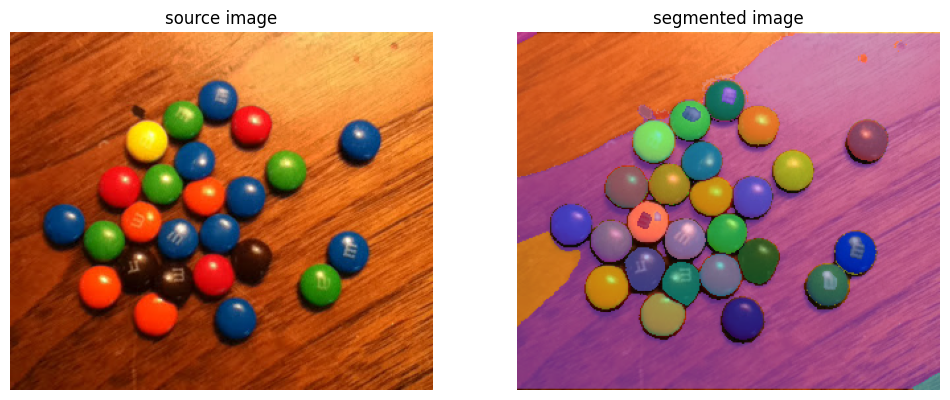

In [125]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

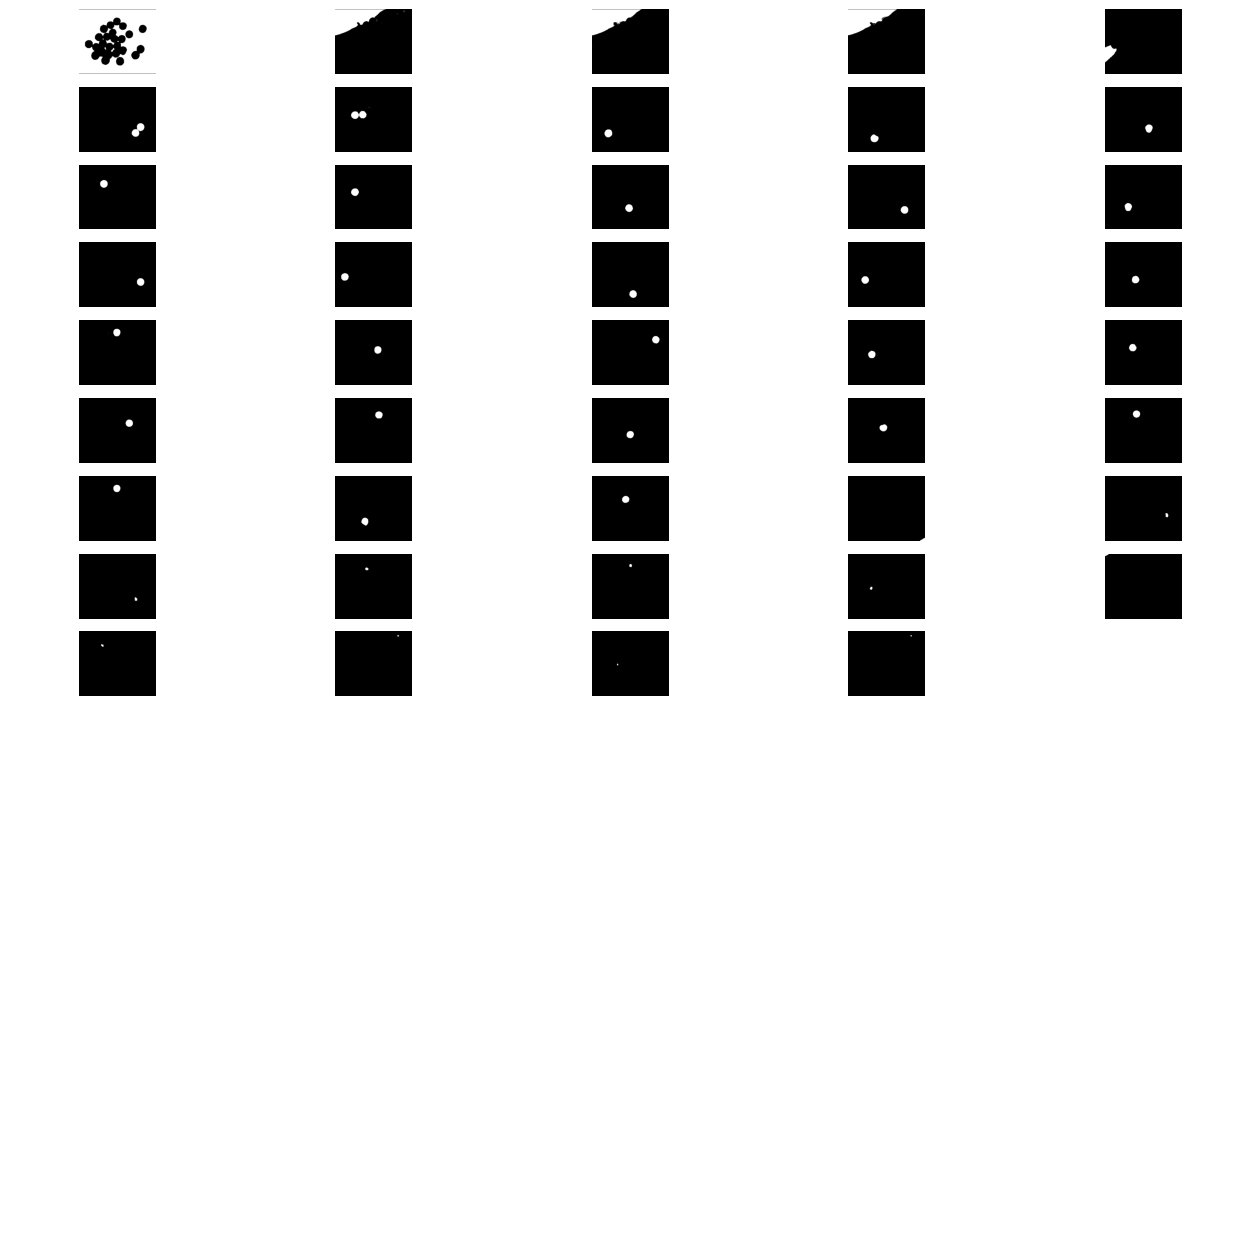

In [126]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]


sv.plot_images_grid(
    images=masks,
    grid_size=(16, int(len(masks) / 8)),
    size=(16, 16)
)

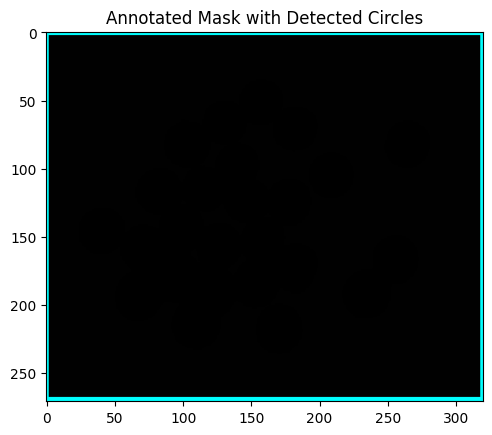

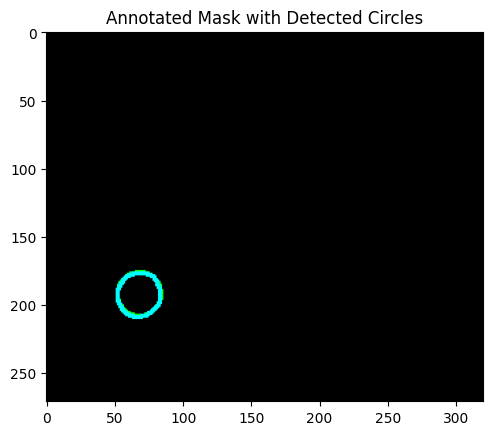

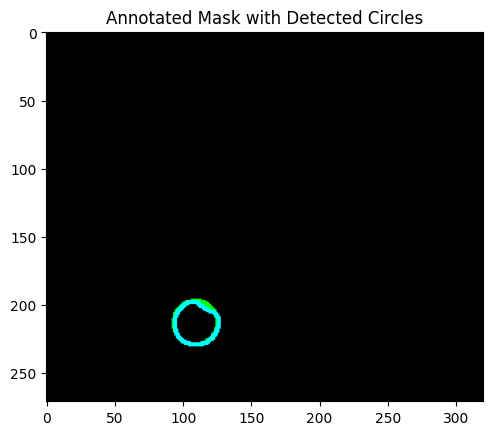

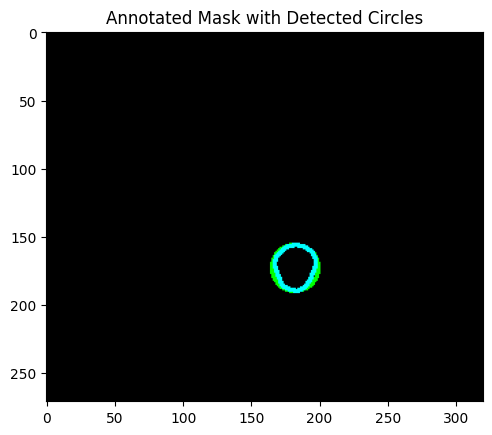

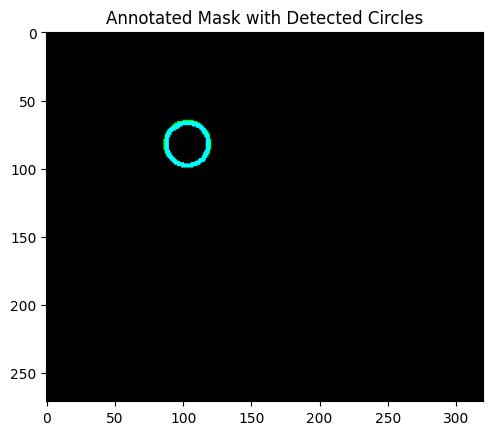

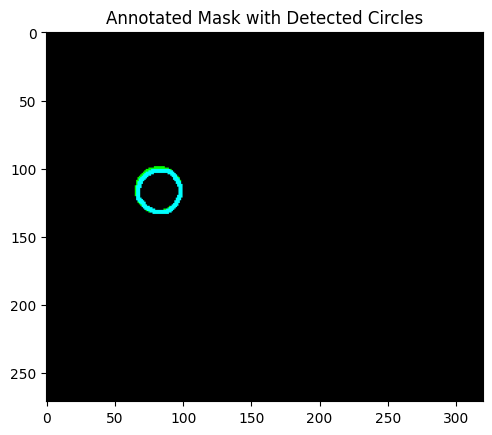

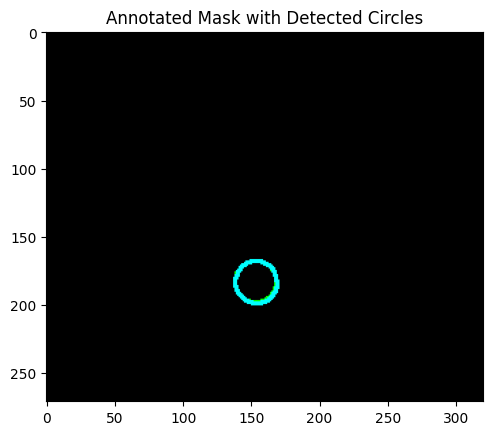

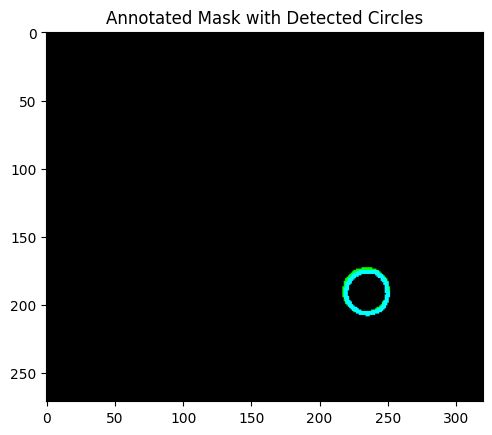

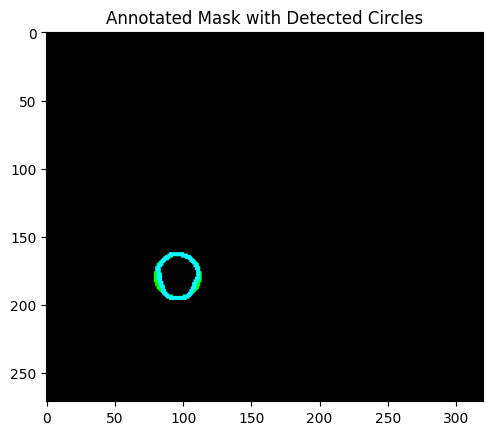

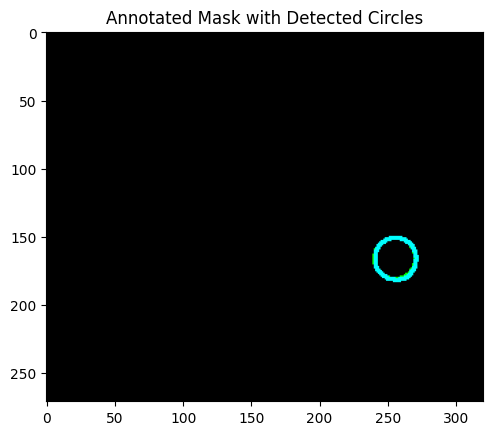

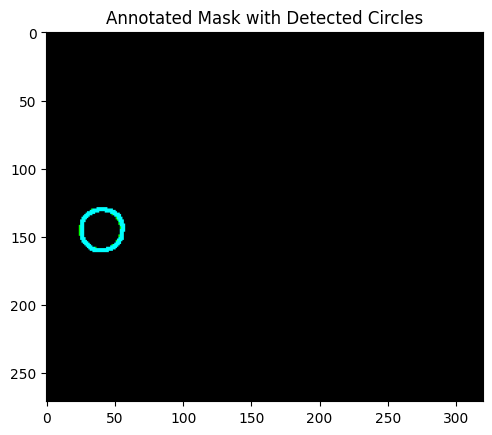

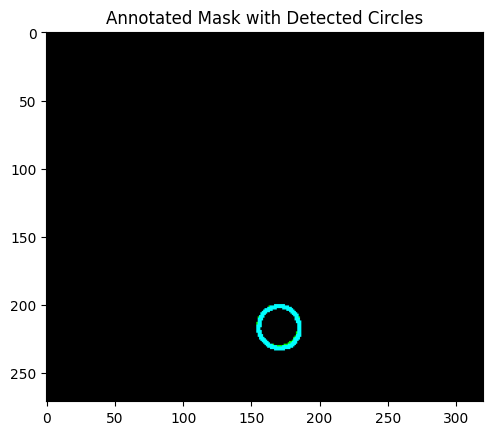

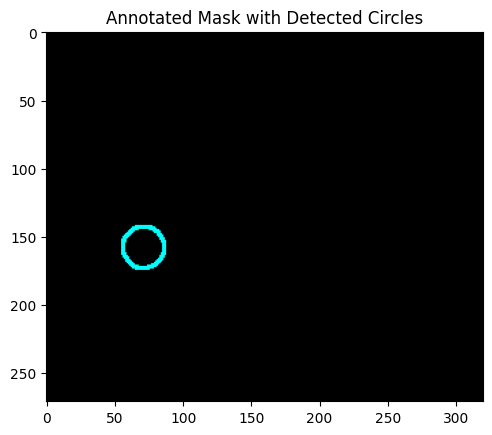

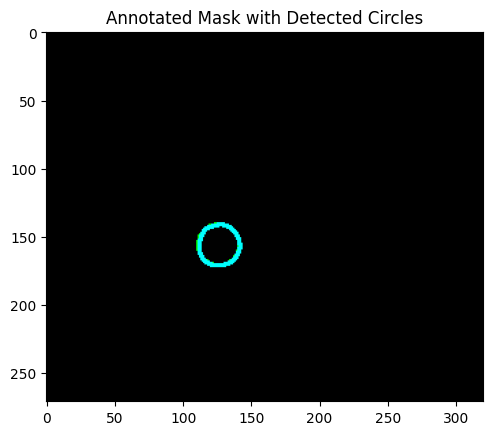

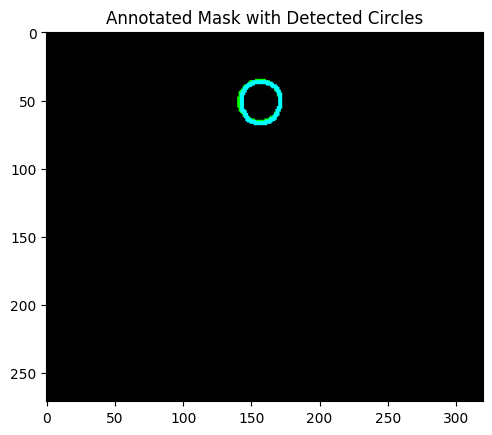

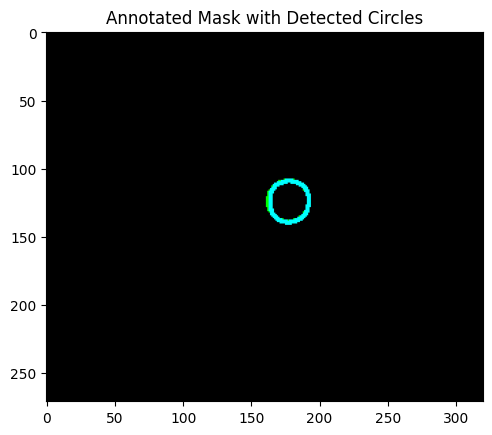

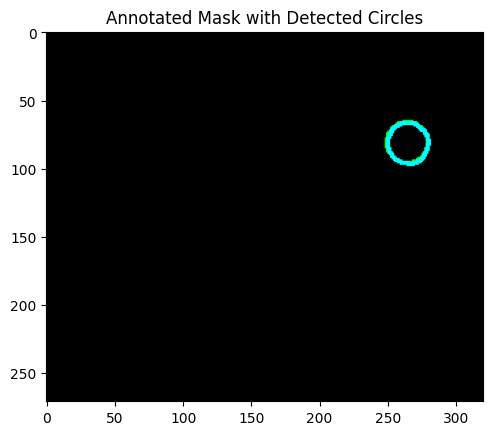

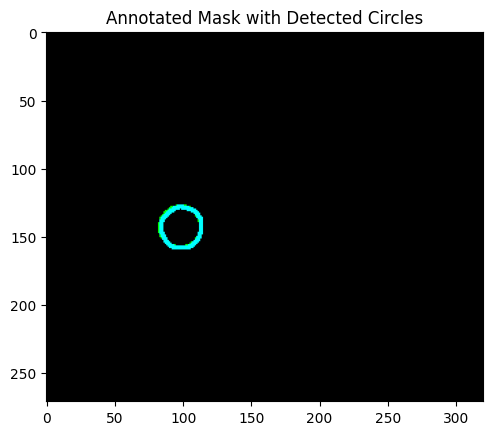

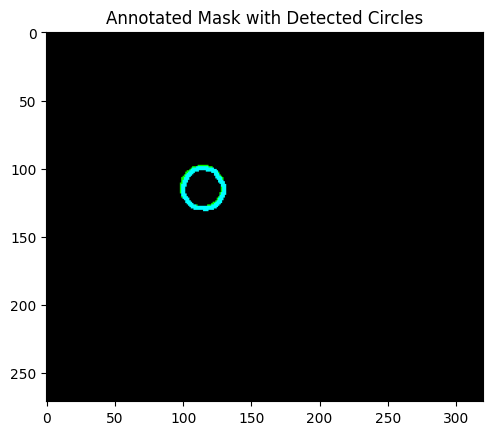

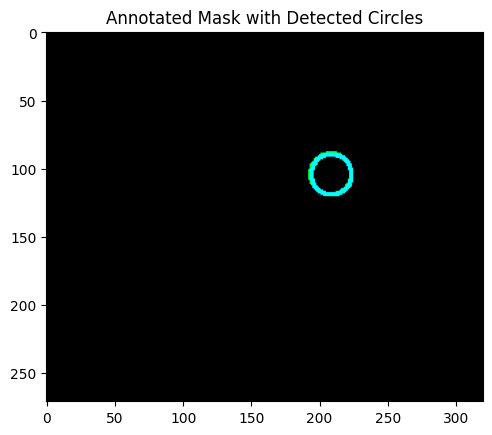

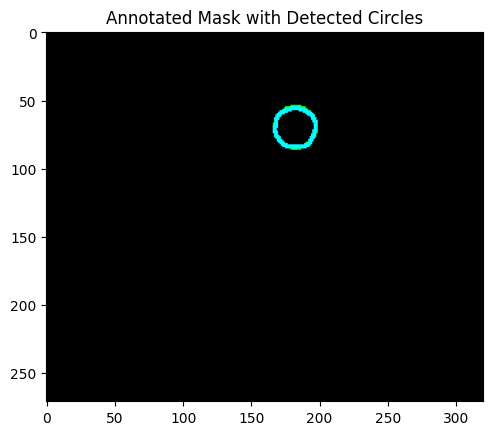

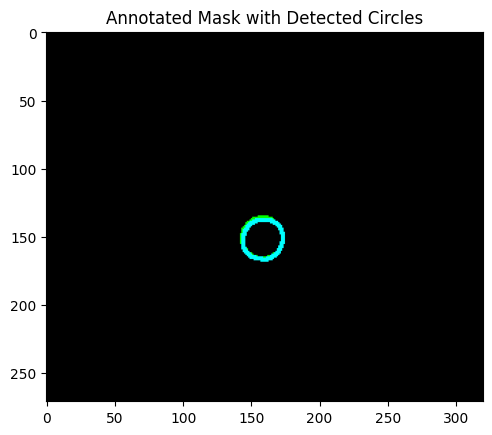

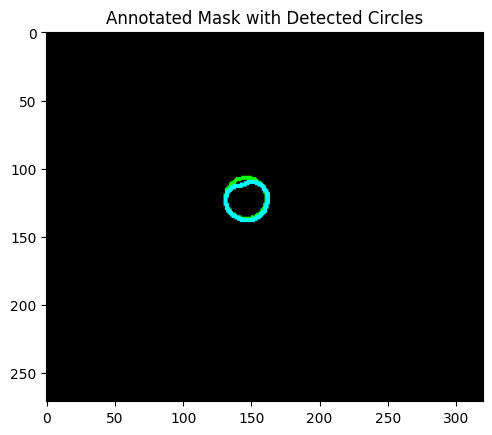

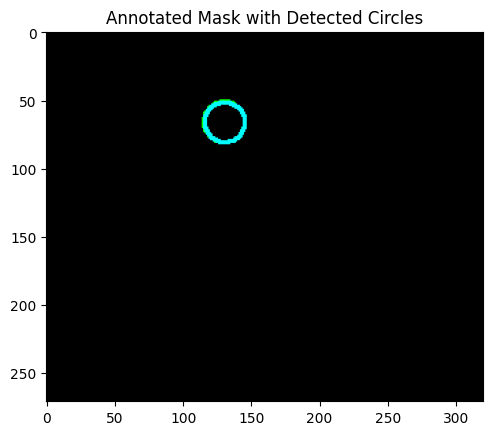

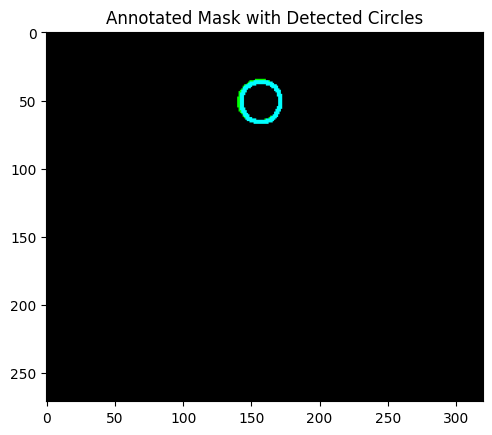

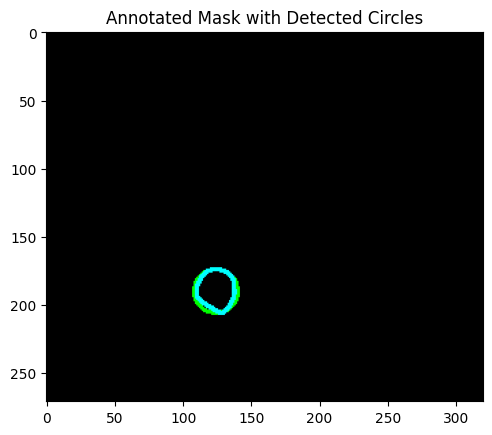

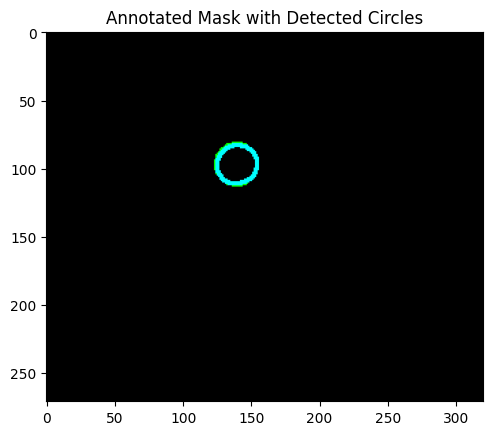

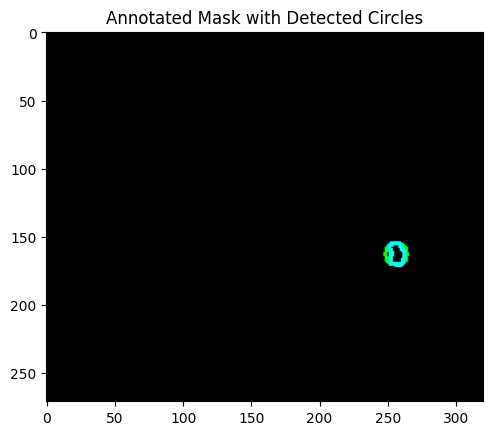

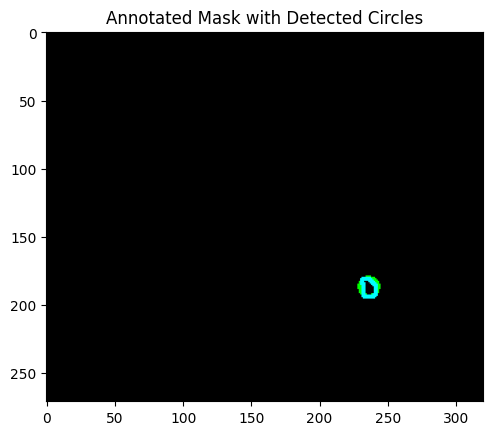

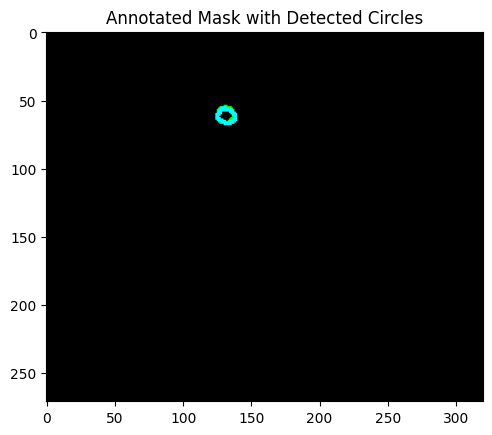

Median circle area: 695.0
Thresholds - Lower: 139.0, Upper: 834.0
Total valid circles detected (after filtering based on area): 26


In [127]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect circles based on contours and circularity
def detect_circles_from_contours(mask):
    mask = mask.astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circle_count = 0
    circle_areas = []  # List to hold the area of each detected circle

    # Initialize the mask_rgb variable
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Skip small contours that are irrelevant
        if area < 100:
            continue

        # Calculate circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # Check if the contour is approximately circular
        if circularity > 0.7:
            # Record the area of the circle
            circle_areas.append(area)

            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)

            # Draw the circle (for debugging purposes)
            cv2.circle(mask_rgb, center, radius, (0, 255, 0), 2)  # Green circle outline
            cv2.drawContours(mask_rgb, [contour], -1, (0, 255, 255), 2)  # Contour outline

            circle_count += 1

    return circle_count, circle_areas, mask_rgb

# Initialize a counter for circles and a list to store all circle areas
total_circle_count = 0
all_circle_areas = []

# Loop through each mask in the sorted masks list
for mask in masks:
    mask_binary = (mask > 0).astype(np.uint8)  # Convert mask to binary (0 or 255)

    # Detect circles from contours and get their areas
    circle_count, circle_areas, annotated_mask = detect_circles_from_contours(mask_binary)

    # If more than 1 circle is found, we skip this mask
    if circle_count != 1:
        continue

    # Add detected circle areas to the list of all areas
    all_circle_areas.extend(circle_areas)

    # Optionally, visualize the annotated mask with circles and contours
    plt.imshow(annotated_mask)
    plt.title("Annotated Mask with Detected Circles")
    plt.show()

# Calculate the median area of detected circles
if all_circle_areas:
    median_area = np.median(all_circle_areas)

    # Calculate the lower and upper thresholds for valid circle areas (using IQR)
    lower_threshold = median_area * 0.2  # For example, 50% lower than the median
    upper_threshold = median_area * 1.2  # For example, 50% higher than the median

    print(f"Median circle area: {median_area}")
    print(f"Thresholds - Lower: {lower_threshold}, Upper: {upper_threshold}")

    # Now filter out circles based on the area thresholds
    valid_circle_count = 0
    for mask in masks:
        mask_binary = (mask > 0).astype(np.uint8)  # Convert mask to binary (0 or 255)

        circle_count, circle_areas, annotated_mask = detect_circles_from_contours(mask_binary)

        if circle_count == 1:  # Only consider masks with exactly 1 circle
            # Filter circles based on area thresholds
            valid_circles = [area for area in circle_areas if lower_threshold <= area <= upper_threshold]
            valid_circle_count += len(valid_circles)

    print(f"Total valid circles detected (after filtering based on area): {valid_circle_count}")
else:
    print("No valid circles detected")


In [128]:
import numpy as np
import cv2

# Define color ranges in HSV to match blue, green, brown, red, orange, yellow
color_ranges = {
    'blue': ((100, 20, 50), (140, 255, 255)),
    'green': ((40, 50, 50), (90, 255, 255)),
    'brown': ((10, 20, 50), (35, 255, 200)),  # Brown in HSV can vary
    'red': ((0, 30, 70), (10, 255, 250)),     # Narrower red range for cherry/strawberry color
    'orange': ((8, 150, 180), (40, 255, 255)), # Expanded range for tangerine to sunset-like color
    'yellow': ((30, 100, 100), (50, 255, 255))
}

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to extract color at centroid based on color ranges
def extract_color_at_centroid(image_rgb, centroid):
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    x, y = centroid
    color_hsv = image_hsv[y, x]

    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower)
        upper = np.array(upper)

        if np.all(color_hsv >= lower) and np.all(color_hsv <= upper):
            return color  # Return the color name if it matches

    return None  # Return None if no color is detected

# Function to detect circles based on contours and circularity
def detect_circles_from_contours(mask):
    mask = mask.astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circle_count = 0
    circle_areas = []  # List to hold the area of each detected circle
    circle_centroids = []  # List to hold centroids of each detected circle

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Skip small contours that are irrelevant
        if area < 100:
            continue

        # Calculate circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # Check if the contour is approximately circular
        if circularity > 0.7:
            # Record the area of the circle
            circle_areas.append(area)

            # Get the centroid using moments
            moments = cv2.moments(contour)
            if moments["m00"] != 0:
                cx = int(moments["m10"] / moments["m00"])
                cy = int(moments["m01"] / moments["m00"])
                circle_centroids.append((cx, cy))

            circle_count += 1

    return circle_count, circle_areas, circle_centroids

# Initialize color count dictionary
color_count = {color: 0 for color in color_ranges}

# Assume 'masks' is a list of binary mask images and 'image_rgb' is the original image
for mask in masks:
    mask_binary = (mask > 0).astype(np.uint8)  # Convert mask to binary (0 or 255)

    # Detect circles from contours and get their areas and centroids
    circle_count, circle_areas, circle_centroids = detect_circles_from_contours(mask_binary)

    if circle_count != 1:
        continue  # Only process masks with exactly 1 circle

    # Calculate the median area of detected circles
    if circle_areas:
        median_area = np.median(circle_areas)
        lower_threshold = median_area * 0.5  # 50% lower than the median
        upper_threshold = median_area * 1.5  # 50% higher than the median

        # Filter out circles based on the area thresholds
        valid_circles = [area for area in circle_areas if lower_threshold <= area <= upper_threshold]

        if valid_circles:
            # Iterate through each valid circle centroid and extract its color
            for centroid in circle_centroids:
                detected_color = extract_color_at_centroid(image_rgb, centroid)
                if detected_color:
                    color_count[detected_color] += 1

# Print the total count of each color found
for color, count in color_count.items():
    print(f"Detected {count} {color} M&Ms.")

# Total number of M&Ms detected
total_m_and_m = sum(color_count.values())
print(f"Total M&Ms detected: {total_m_and_m}")



Detected 9 blue M&Ms.
Detected 5 green M&Ms.
Detected 3 brown M&Ms.
Detected 3 red M&Ms.
Detected 4 orange M&Ms.
Detected 1 yellow M&Ms.
Total M&Ms detected: 25


In [136]:
import numpy as np
import cv2

# Function to calculate Euclidean distance between two points
def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

# Function to detect circles from contours and circularity
def detect_circles_from_contours(mask):
    mask = mask.astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circle_count = 0
    circle_areas = []  # List to hold the area of each detected circle
    circle_centroids = []  # List to hold centroids of each detected circle

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Skip small contours that are irrelevant
        if area < 100:
            continue

        # Calculate circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # Check if the contour is approximately circular
        if circularity > 0.7:
            # Record the area of the circle
            circle_areas.append(area)

            # Get the centroid using moments
            moments = cv2.moments(contour)
            if moments["m00"] != 0:
                cx = int(moments["m10"] / moments["m00"])
                cy = int(moments["m01"] / moments["m00"])
                circle_centroids.append((cx, cy))

            circle_count += 1

    return circle_count, circle_areas, circle_centroids

# Initialize color count dictionary
color_count = {color: 0 for color in color_ranges}
previous_centroids = []  # List to store centroids of previously detected circles
centroid_threshold = 2  # Distance threshold (in pixels) to exclude close centroids

# Assume 'masks' is a list of binary mask images and 'image_rgb' is the original image
for mask in masks:
    mask_binary = (mask > 0).astype(np.uint8)  # Convert mask to binary (0 or 255)

    # Detect circles from contours and get their areas and centroids
    circle_count, circle_areas, circle_centroids = detect_circles_from_contours(mask_binary)

    if circle_count != 1:
        continue  # Only process masks with exactly 1 circle

    # Calculate the median area of detected circles
    if circle_areas:
        median_area = np.median(circle_areas)
        lower_threshold = median_area * 0.5  # 50% lower than the median
        upper_threshold = median_area * 1.5  # 50% higher than the median

        # Filter out circles based on the area thresholds
        valid_circles = [area for area in circle_areas if lower_threshold <= area <= upper_threshold]

        if valid_circles:
            # Iterate through each valid circle centroid and extract its color
            for centroid in circle_centroids:
                # Check if centroid is too close to any previously detected centroid
                is_duplicate = False
                for prev_centroid in previous_centroids:
                    if euclidean_distance(centroid, prev_centroid) < centroid_threshold:
                        is_duplicate = True
                        break  # Exit the loop as we found a close centroid

                if is_duplicate:
                    continue  # Skip processing if centroid is too close to a previous one

                # Mark the centroid as detected
                previous_centroids.append(centroid)

                detected_color = extract_color_at_centroid(image_rgb, centroid)
                if detected_color:
                    color_count[detected_color] += 1

# Print the total count of each color found
for color, count in color_count.items():
    print(f"Detected {count} {color} M&Ms.")

# Total number of M&Ms detected
total_m_and_m = sum(color_count.values())
print(f"Total M&Ms detected: {total_m_and_m}")


Detected 8 blue M&Ms.
Detected 5 green M&Ms.
Detected 3 brown M&Ms.
Detected 3 red M&Ms.
Detected 4 orange M&Ms.
Detected 1 yellow M&Ms.
Total M&Ms detected: 24
